## Transfer Learning
Entrenar una red neuronal utilizando un modelo ya pre-entrenado

In [1]:
# Cargamos las librerías necesarias
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

torch.manual_seed(0)

#### Dataset information
- 240 imágenes de entrenamiento y 150 de test/validación. Son imágenes de Abejas y Hormigas. Se pueden descargar en los enlaces de abajo

- There are 240 training images and 150 validation images divided equally between the two classes (bees and ants). 
- We download the dataset from this link - https://www.kaggle.com/ajayrana/hymenoptera-data and store it in the current working directory. 
- In order to download the dataset you will need to login to kaggle. If you do not already have a kaggle account, you will need to register.
- More information about the dataset can be found here: https://hymenoptera.elsiklab.missouri.edu/

In [2]:
# Carpeta donde deberéis meter los datos descargados
ddir = 'hymenoptera_data'

# Aquí se cargan los datos y los normalizamos. Para incrementar el número de muestras de entrenamiento vamos a aplicarle un
# "resize" aleatorio y un giro a la imagen. Lo mismo hacemos para el conjunto de test (solamente en la normalización)

# The mean and std for normalization are calculated as the mean of all pixel values for all images in the training set per each image channel - R, G and B
data_transformers = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])]),
    'val': transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), 
                                      transforms.ToTensor(), 
                                      transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])])}

# Una vez que los tenemos, los cargamos
img_data = {k: datasets.ImageFolder(os.path.join(ddir, k), data_transformers[k]) for k in ['train', 'val']}
dloaders = {k: torch.utils.data.DataLoader(img_data[k], batch_size=8, shuffle=True, num_workers=2) 
            for k in ['train', 'val']}
dset_sizes = {x: len(img_data[x]) for x in ['train', 'val']}
classes = img_data['train'].classes
dvc = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

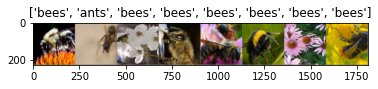

In [3]:
# Función para imprimir unas imágenes
def imageshow(img, text=None):
    img = img.numpy().transpose((1, 2, 0))
    avg = np.array([0.490, 0.449, 0.411])
    stddev = np.array([0.231, 0.221, 0.230])
    img = stddev * img + avg
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if text is not None:
        plt.title(text)

# Genera un batch de imágenes de entrenamiento
imgs, cls = next(iter(dloaders['train']))

# Genera un grid del batch de entrenamiento para visualizar
grid = torchvision.utils.make_grid(imgs)

imageshow(grid, text=[classes[c] for c in cls])

In [4]:
# Definimos la función de entrenamiento. Por favor, fijarse que hacemos una COPIA de los pesos de la red ya entranada para ganar enteros
def finetune_model(pretrained_model, loss_func, optim, epochs=10):
    start = time.time()
    pretrained_model.to(dvc)

    model_weights = copy.deepcopy(pretrained_model.state_dict())
    accuracy = 0.0

    for e in range(epochs):
        print(f'Epoch number {e}/{epochs - 1}')
        print('=' * 20)

        # for each epoch we run through the training and validation set
        for dset in ['train', 'val']:
            if dset == 'train':
                pretrained_model.train()  # set model to train mode (i.e. trainbale weights)
            else:
                pretrained_model.eval()   # set model to validation mode

            loss = 0.0
            successes = 0

            # iterate over the (training/validation) data.
            for imgs, tgts in dloaders[dset]:
                imgs = imgs.to(dvc)
                tgts = tgts.to(dvc)
                optim.zero_grad()
                
                with torch.set_grad_enabled(dset == 'train'):
                    ops = pretrained_model(imgs)
                    _, preds = torch.max(ops, 1)
                    loss_curr = loss_func(ops, tgts)
                    # backward pass only if in training mode
                    if dset == 'train':
                        loss_curr.backward()
                        optim.step()

                loss += loss_curr.item() * imgs.size(0)
                successes += torch.sum(preds == tgts.data)

            loss_epoch = loss / dset_sizes[dset]
            accuracy_epoch = successes.double() / dset_sizes[dset]

            print(f'{dset} loss in this epoch: {loss_epoch}, accuracy in this epoch: {accuracy_epoch}')
            if dset == 'val' and accuracy_epoch > accuracy:
                accuracy = accuracy_epoch
                model_weights = copy.deepcopy(pretrained_model.state_dict())
        print()

    time_delta = time.time() - start
    print(f'Training finished in {time_delta // 60}mins {time_delta % 60}secs')
    print(f'Best validation set accuracy: {accuracy}')

    # load the best model version (weights)
    pretrained_model.load_state_dict(model_weights)
    return pretrained_model

In [5]:
# Función auxiliar para dibujar unas predicciones
def visualize_predictions(pretrained_model, max_num_imgs=8):
    torch.manual_seed(1)
    was_model_training = pretrained_model.training
    pretrained_model.eval()
    imgs_counter = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (imgs, tgts) in enumerate(dloaders['val']):
            imgs = imgs.to(dvc)
            tgts = tgts.to(dvc)
            ops = pretrained_model(imgs)
            _, preds = torch.max(ops, 1)
            
            for j in range(imgs.size()[0]):
                imgs_counter += 1
                ax = plt.subplot(max_num_imgs//2, 2, imgs_counter)
                ax.axis('off')
                ax.set_title(f'pred: {classes[preds[j]]} || target: {classes[tgts[j]]}')
                imageshow(imgs.cpu().data[j])

                if imgs_counter == max_num_imgs:
                    pretrained_model.train(mode=was_model_training)
                    return
        pretrained_model.train(mode=was_model_training)

In [2]:
model_finetune = models.alexnet(pretrained=True)
model_finetune.to(dvc)
print(model_finetune.features)

NameError: name 'dvc' is not defined

In [ ]:
print(model_finetune.classifier)

In [ ]:
# Ahora cogemos la red que ya ha sido entrenada y le modificamos la última capa para que en vez de ser capaz de identificar 1000 clases, simplemente lo haga con 2
model_finetune.classifier[6] = nn.Linear(4096, len(classes))

loss_func = nn.CrossEntropyLoss()
optim_finetune = optim.SGD(model_finetune.parameters(), lr=0.0001)

# train (fine-tune) and validate the model
model_finetune = finetune_model(model_finetune, loss_func, optim_finetune, epochs=10)

In [ ]:
visualize_predictions(model_finetune)